# Parsing

In [1]:
import json
import re
from typing import Dict, Iterable, List, Tuple
import os

mixtral_filename = os.path.join("data", "mixtral_results_5_percent.json")
llama_filename = os.path.join("data", "llama_top_5_percent.json")

filter_docs = {2408, 5053, 6921, 10670, 12195, 18813, 22245}


def load_scores(filename: str) -> Iterable[Tuple[int, int]]:
    with open(filename, "r") as f:
        data = json.load(f)
        for id, text in data:
            id = int(id)
            if id not in filter_docs:
                score = _parse_score(id, text)
                if score in {-1, 0, 1, 2, 3, 4, 5}:
                    yield id, _parse_score(id, text)
                else:
                    print(f"Errornous score for doc {id=}: {score=}")


def _parse_score(id: int, text: str) -> int:
    matches = re.findall(r"Educational score: (-?\d+)", text)
    if not matches:
        matches = re.findall(r"(-?\d+) point", text)
    if not matches:
        matches = re.findall(r"score:(-?\d+)", text)
    if not matches:
        matches = re.findall(r"educational score is (-?\d+)", text)
    if not matches and (
        "Educational score: Not applicable" in text or "I'm sorry" in text
    ):
        matches = [-1]
    if not matches:
        raise ValueError(f"Parsing error in file {id} with text:\n{text}")
    return int(matches[-1])


# def _parse_score(id: int, text: str) -> int:
#     text_split = text.split(" ")
#     try:
#         return _try_parse_score(text_split[-1])
#     except ValueError as e1:
#         try:
#             return _try_parse_score(text_split[-2])
#         except ValueError as e2:
#             print(f"Error for {id=}:\n{e1=}\n{e2=}")
#             raise


# def _try_parse_score(score_text: str) -> int:
#     if "/" in score_text:
#         return int(score_text.split("/")[0])
#     int(score_text)


mixtral_data = dict(load_scores(mixtral_filename))
llama_data = dict(load_scores(llama_filename))

Errornous score for doc id=19681: score=50


In [2]:
print(f"Mixtral only keys: {list(set(mixtral_data).difference(llama_data))}")
print(f"Llama only keys:   {list(set(llama_data).difference(mixtral_data))}")
common_keys = set(mixtral_data).intersection(llama_data)

Mixtral only keys: []
Llama only keys:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 19681]


In [3]:
minus_one_mixtral = [k for k, v in mixtral_data.items() if v == -1]
minus_one_llama = [k for k, v in llama_data.items() if v == -1]
minus_one_mixtral

[3721, 5418, 14771, 17679, 19700]

In [4]:
eval_keys = list(common_keys.difference(minus_one_mixtral))
len(eval_keys)

24833

# Score comparison

In [5]:
count_same_score = sum(mixtral_data[k] == llama_data[k] for k in eval_keys)
print(f"{count_same_score=}\npercentage={count_same_score / len(eval_keys)}")

count_same_score=10738
percentage=0.43240848870454635


In [6]:
count_close_score = sum(abs(mixtral_data[k] - llama_data[k]) <= 1 for k in eval_keys)
print(f"{count_close_score=}\npercentage={count_close_score / len(eval_keys)}")

count_close_score=22607
percentage=0.9103612129021866


In [7]:
count_not_close_score = sum(abs(mixtral_data[k] - llama_data[k]) > 1 for k in eval_keys)
print(f"{count_not_close_score=}\npercentage={count_not_close_score / len(eval_keys)}")

count_not_close_score=2226
percentage=0.0896387870978134


In [17]:
count_not_close_at_all_score = sum(abs(mixtral_data[k] - llama_data[k]) > 2 for k in eval_keys)
print(f"{count_not_close_at_all_score=}\npercentage={count_not_close_at_all_score / len(eval_keys)}")

count_not_close_at_all_score=288
percentage=0.011597471106994725


: 

In [8]:
count_mixtral_larger_score = sum(llama_data[k] - mixtral_data[k] < 0 for k in eval_keys)
print(f"{count_mixtral_larger_score=}\npercentage={count_mixtral_larger_score / len(eval_keys)}")

count_mixtral_larger_score=1692
percentage=0.068135142753594


In [9]:
count_llama_larger_score = sum(mixtral_data[k] - llama_data[k] < 0 for k in eval_keys)
print(f"{count_llama_larger_score=}\npercentage={count_llama_larger_score / len(eval_keys)}")

count_llama_larger_score=12403
percentage=0.4994563685418596


In [10]:
both_larger_three_count = sum(mixtral_data[k] >= 3 and llama_data[k] >= 3  for k in eval_keys)
only_mistral_larger_three_count = sum(mixtral_data[k] >= 3 and llama_data[k] < 3  for k in eval_keys)
only_llama_larger_three_count = sum(mixtral_data[k] < 3 and llama_data[k] >= 3  for k in eval_keys)
print(f"{both_larger_three_count=}\npercentage={both_larger_three_count / len(eval_keys)}")
print(f"{only_mistral_larger_three_count=}\npercentage={only_mistral_larger_three_count / len(eval_keys)}")
print(f"{only_llama_larger_three_count=}\npercentage={only_llama_larger_three_count / len(eval_keys)}")

both_larger_three_count=880
percentage=0.03543671727137277
only_mistral_larger_three_count=718
percentage=0.028913139773688236
only_llama_larger_three_count=1425
percentage=0.057383320581484314


In [11]:
both_larger_two_count = sum(mixtral_data[k] >= 2 and llama_data[k] >= 2  for k in eval_keys)
only_mistral_larger_two_count = sum(mixtral_data[k] >= 2 and llama_data[k] < 2  for k in eval_keys)
only_llama_larger_two_count = sum(mixtral_data[k] < 2 and llama_data[k] >= 2  for k in eval_keys)
print(f"{both_larger_two_count=}\npercentage={both_larger_two_count / len(eval_keys)}")
print(f"{only_mistral_larger_two_count=}\npercentage={only_mistral_larger_two_count / len(eval_keys)}")
print(f"{only_llama_larger_two_count=}\npercentage={only_llama_larger_two_count / len(eval_keys)}")

both_larger_two_count=2495
percentage=0.10047114726372167
only_mistral_larger_two_count=644
percentage=0.025933234003140983
only_llama_larger_two_count=5394
percentage=0.21721096927475536


mean of absolute score differences = 0.6699955704103411


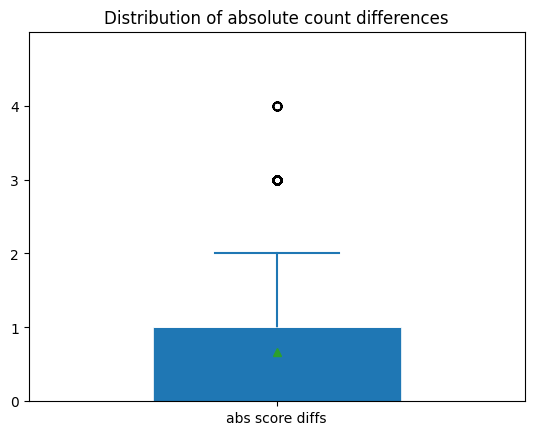

In [12]:
import matplotlib.pyplot as plt
import numpy as np

sorted_eval_keys = sorted(eval_keys)

mixtral_data_np = np.array([mixtral_data[k] for k in sorted_eval_keys])
llama_data_np = np.array([llama_data[k] for k in sorted_eval_keys])

score_diff_abs = np.abs(mixtral_data_np - llama_data_np)

fig, ax = plt.subplots()
VP = ax.boxplot(
    score_diff_abs,
    positions=[1],
    widths=1.0,
    patch_artist=True,
    showmeans=True,
    showfliers=True,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
)

ax.set(
    xlim=(0, 2),
    xticks=[1],
    xticklabels=["abs score diffs"],
    ylim=(0, 5),
    yticks=np.arange(0, 5),
)

print("mean of absolute score differences =", score_diff_abs.mean())

plt.title("Distribution of absolute count differences")

plt.show()

mean of score differences = -0.5121411025651351


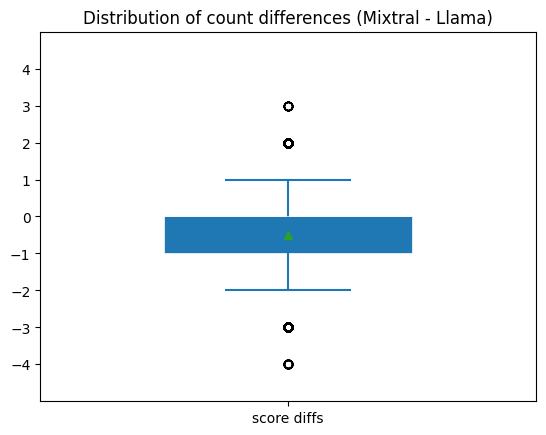

In [13]:
score_diff = mixtral_data_np - llama_data_np

fig, ax = plt.subplots()
VP = ax.boxplot(
    score_diff,
    positions=[1],
    widths=1.0,
    patch_artist=True,
    showmeans=True,
    showfliers=True,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
)

ax.set(
    xlim=(0, 2),
    xticks=[1],
    xticklabels=["score diffs"],
    ylim=(-5, 5),
    yticks=np.arange(-4, 5),
)

print("mean of score differences =", score_diff.mean())

plt.title("Distribution of count differences (Mixtral - Llama)")

plt.show()

Mixtral mean: 0.7584262876011758
Llama mean: 1.270567390166311


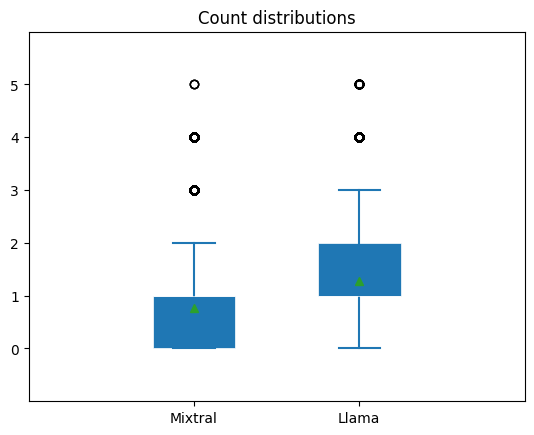

In [14]:
D = [mixtral_data_np, llama_data_np]

fig, ax = plt.subplots()
VP = ax.boxplot(
    D,
    positions=[2, 4],
    widths=1.0,
    patch_artist=True,
    showmeans=True,
    showfliers=True,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
)

ax.set(
    xlim=(0, 6),
    xticks=np.array([2, 4]),
    xticklabels=["Mixtral", "Llama"],
    ylim=(-1, 6),
    yticks=np.arange(0, 6),
)

print("Mixtral mean:", mixtral_data_np.mean())
print("Llama mean:", llama_data_np.mean())

plt.title('Count distributions')

plt.show()

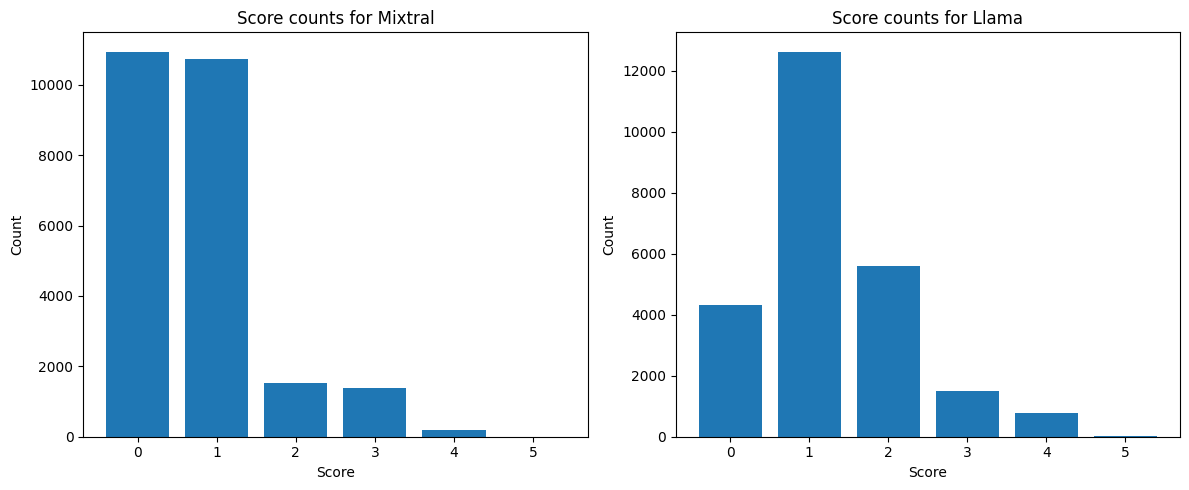

In [15]:
mixtral_counts = np.bincount(mixtral_data_np)
llama_counts = np.bincount(llama_data_np)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(range(len(mixtral_counts)), mixtral_counts)
ax1.set_xlabel('Score')
ax1.set_ylabel('Count')
ax1.set_title('Score counts for Mixtral')

ax2.bar(range(len(llama_counts)), llama_counts)
ax2.set_xlabel('Score')
ax2.set_ylabel('Count')
ax2.set_title('Score counts for Llama')

plt.tight_layout()
plt.show()